# ADC Survey: Aperture Plot

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
try:
    from google.colab import files
    IN_COLAB = True
except:
    IN_COLAB = False

download = False

In [3]:
# Read latest survey data and concatenate ISSCC and VLSI data
# data = "../xls/ADCsurvey_latest.xlsx"
data = "https://github.com/bmurmann/ADC-survey/blob/main/xls/ADCsurvey_latest.xlsx?raw=true"
df1 = pd.read_excel(data, sheet_name='ISSCC')
df2 = pd.read_excel(data, sheet_name='VLSI')
df = pd.concat([df1, df2])

In [4]:
# Show headers of data table
print(df.keys())

Index(['YEAR', 'ID', 'TYPE', 'ARCHITECTURE', 'TECHNOLOGY', 'TITLE', 'ABSTRACT',
       'AUTHORS', 'DOI', 'LINK', 'COMMENTS', 'VSUP1 [V]', 'VSUP2 [V]',
       'VSUP3 [V]', 'Csamp [pF]', 'AREA [mm^2]', 'SNDR_lf [dB]', 'fin_hf [Hz]',
       'SNDR_hf [dB]', 'SNR [dB]', 'DR [dB]', '-THD [dB]', 'SFDR [dB]',
       'SNDR_plot [dB]', 'P [W]', 'fs [Hz]', 'OSR', 'fsnyq [Hz]',
       'fcenter [Hz]', 'P/fsnyq [pJ]', 'FOMW_lf [fJ/conv-step]',
       'FOMW_hf [fJ/conv-step]', 'FOMS_lf [dB]', 'FOMS_hf [dB]',
       'FOMW_hf/fsnyq', 'FOMS,hf+10log(fsnyq)'],
      dtype='object')


In [5]:
# Compute envelope for aperture plot
jitter_estimate = 1/(2*np.pi*df['fin_hf [Hz]'] * np.sqrt(10**(df['SNDR_hf [dB]']/10)))
smallest_three = sorted(jitter_estimate, key = lambda x : float('inf') if np.isnan(x) else x)[:3]
jitter_min = np.mean(smallest_three)
jitter_max = 1e-12
env_x = np.linspace(1e6, 1e11, 100)
env_y1 = -20*np.log10(2*np.pi*env_x*jitter_min)
env_y2 = -20*np.log10(2*np.pi*env_x*jitter_max)

In [6]:
# Decent settings for a PowerPoint figure
font=16
size=(8, 5)

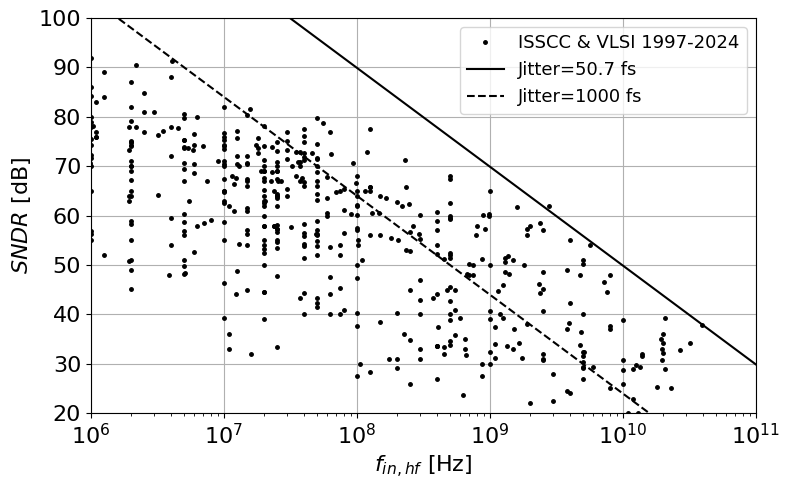

In [7]:
fig, ax = plt.subplots(figsize=size)
ax.plot(df['fin_hf [Hz]'], df['SNDR_hf [dB]'], 'k.', ms=5, label='ISSCC & VLSI 1997-%d' %max(df['YEAR']))
ax.plot(env_x, env_y1, 'k', label='Jitter=%.1f fs' %(jitter_min/1e-15))
ax.plot(env_x, env_y2, 'k--', label='Jitter=%.0f fs' %(jitter_max/1e-15))
ax.legend(frameon=1, fontsize=font-3)
ax.set_xscale('log')
ax.set_xlim((1e6, 1e11))
ax.set_ylim((20, 100))
plt.xticks(fontsize=font)
plt.yticks(fontsize=font)
plt.xlabel('$f_{in,hf}$ [Hz]', fontsize=font)
plt.ylabel('$SNDR$ [dB]', fontsize=font)
plt.grid(True)
fig.tight_layout()
plt.show()

In [8]:
# save and download as high-resolution png file
if download:
  fig.savefig("aperture_plot_all.png", dpi=600)
  if IN_COLAB:
    files.download('aperture_plot_all.png')

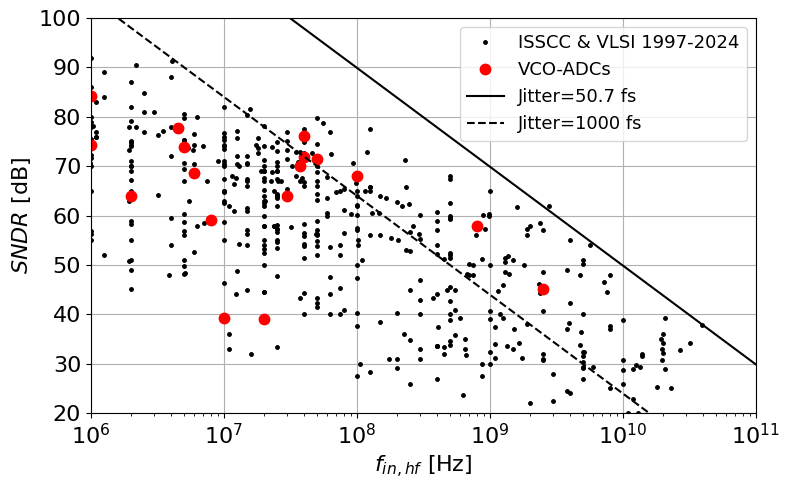

In [9]:
fig, ax = plt.subplots(figsize=size)
vco_df = df.query("ARCHITECTURE.str.contains('VCO', case=False)")
ax.plot(df['fin_hf [Hz]'], df['SNDR_hf [dB]'], 'k.', ms=5, label='ISSCC & VLSI 1997-%d' %max(df['YEAR']))
ax.plot(vco_df['fin_hf [Hz]'], vco_df['SNDR_hf [dB]'], 'r.', ms=15, label='VCO-ADCs')
ax.plot(env_x, env_y1, 'k', label='Jitter=%.1f fs' %(jitter_min/1e-15))
ax.plot(env_x, env_y2, 'k--', label='Jitter=%.0f fs' %(jitter_max/1e-15))
ax.legend(frameon=1, fontsize=font-3)
ax.set_xscale('log')
ax.set_xlim((1e6, 1e11))
ax.set_ylim((20, 100))
plt.xticks(fontsize=font)
plt.yticks(fontsize=font)
plt.xlabel('$f_{in,hf}$ [Hz]', fontsize=font)
plt.ylabel('$SNDR$ [dB]', fontsize=font)
plt.grid(True)
fig.tight_layout()
plt.show()

In [10]:
# save and download as high-resolution png file
if download:
  fig.savefig("aperture_plot.png", dpi=600)
  if IN_COLAB:
    files.download('aperture_plot.png')

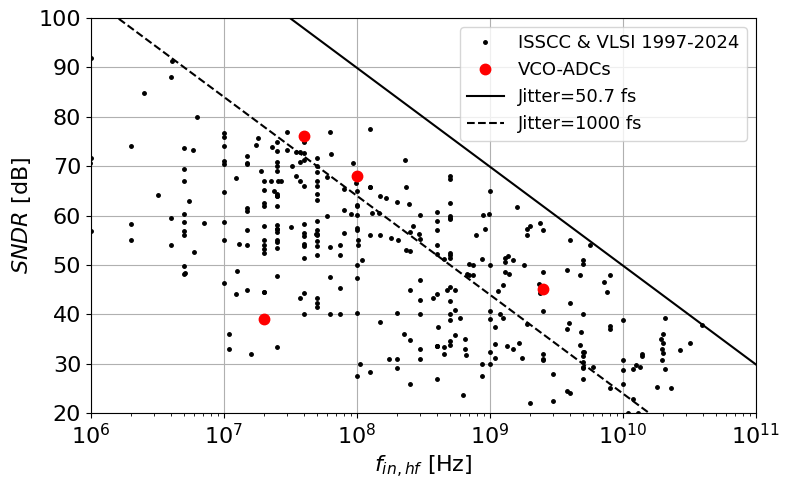

In [11]:
df_nq = df.query("TYPE.str.contains('NQ', case=False)")
fig, ax = plt.subplots(figsize=size)
vco_df_nq = df_nq.query("ARCHITECTURE.str.contains('VCO', case=False)")
ax.plot(df_nq['fin_hf [Hz]'], df_nq['SNDR_hf [dB]'], 'k.', ms=5, label='ISSCC & VLSI 1997-%d' %max(df['YEAR']))
ax.plot(vco_df_nq['fin_hf [Hz]'], vco_df_nq['SNDR_hf [dB]'], 'r.', ms=15, label='VCO-ADCs')
ax.plot(env_x, env_y1, 'k', label='Jitter=%.1f fs' %(jitter_min/1e-15))
ax.plot(env_x, env_y2, 'k--', label='Jitter=%.0f fs' %(jitter_max/1e-15))
ax.legend(frameon=1, fontsize=font-3)
ax.set_xscale('log')
ax.set_xlim((1e6, 1e11))
ax.set_ylim((20, 100))
plt.xticks(fontsize=font)
plt.yticks(fontsize=font)
plt.xlabel('$f_{in,hf}$ [Hz]', fontsize=font)
plt.ylabel('$SNDR$ [dB]', fontsize=font)
plt.grid(True)
fig.tight_layout()
plt.show()

In [12]:
# save and download as high-resolution png file
if download:
  fig.savefig("aperture_plot_nq.png", dpi=600)
  if IN_COLAB:
    files.download('aperture_plot_nq.png')

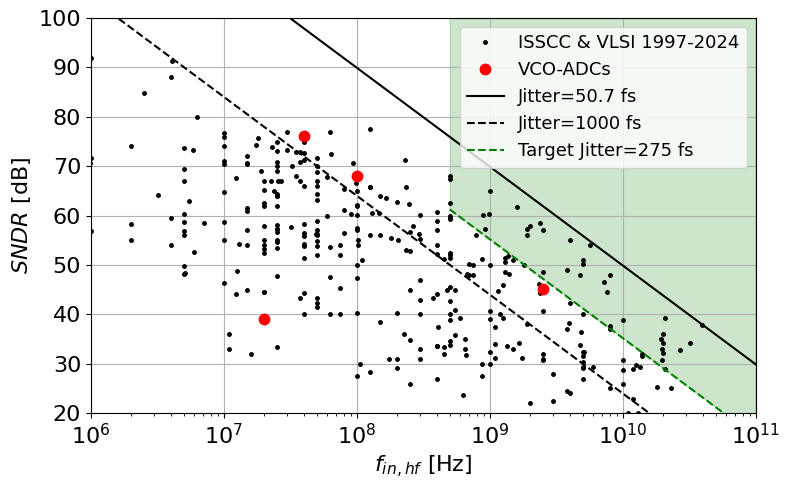

In [13]:
df_nq = df.query("TYPE.str.contains('NQ', case=False)")
fig, ax = plt.subplots(figsize=size)
vco_df_nq = df_nq.query("ARCHITECTURE.str.contains('VCO', case=False)")
ax.plot(df_nq['fin_hf [Hz]'], df_nq['SNDR_hf [dB]'], 'k.', ms=5, label='ISSCC & VLSI 1997-%d' %max(df['YEAR']))
ax.plot(vco_df_nq['fin_hf [Hz]'], vco_df_nq['SNDR_hf [dB]'], 'r.', ms=15, label='VCO-ADCs')
ax.plot(env_x, env_y1, 'k', label='Jitter=%.1f fs' %(jitter_min/1e-15))
ax.plot(env_x, env_y2, 'k--', label='Jitter=%.0f fs' %(jitter_max/1e-15))
jitter_target = (jitter_min+jitter_max-500e-15)/2
env_x_target = np.linspace(500e6, 1e11, 100)
env_y_target = -20*np.log10(2*np.pi*env_x_target*jitter_target)
plt.fill_between(env_x_target, env_y_target, 100, color='green',alpha=0.2)
ax.plot(env_x_target, env_y_target, 'g--', label='Target Jitter=%.0f fs' %(jitter_target/1e-15))
# plt.axvspan(500000000, 1e11, color='green', alpha=0.2)
ax.legend(frameon=1, fontsize=font-3)
ax.set_xscale('log')
ax.set_xlim((1e6, 1e11))
ax.set_ylim((20, 100))
plt.xticks(fontsize=font)
plt.yticks(fontsize=font)
plt.xlabel('$f_{in,hf}$ [Hz]', fontsize=font)
plt.ylabel('$SNDR$ [dB]', fontsize=font)
plt.grid(True)
fig.tight_layout()
plt.show()

In [14]:
# save and download as high-resolution png file
if download:
  fig.savefig("aperture_plot_nq_bw.png", dpi=600)
  if IN_COLAB:
    files.download('aperture_plot_nq_bw.png')

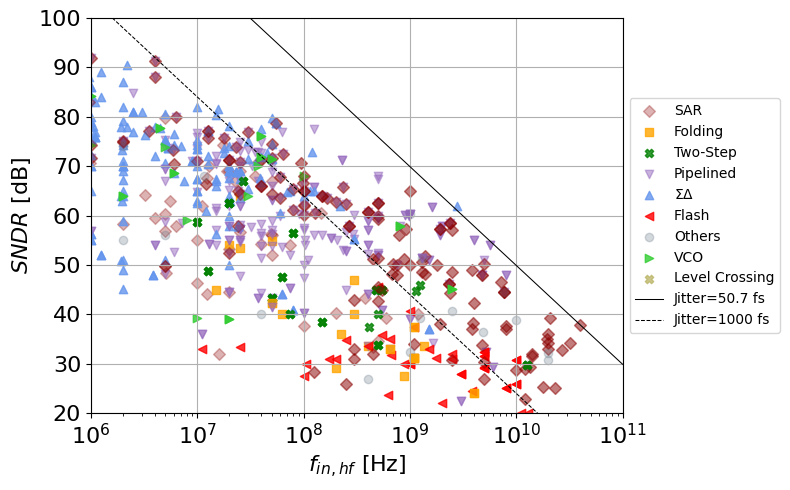

In [72]:
fig, ax = plt.subplots(figsize=size)

for arch in df['ARCHITECTURE'].unique():
  df_temp = df.query(f"ARCHITECTURE.str.contains('{arch}', case=False)")
  # print(arch)
  if "SAR" in arch:
      ax.scatter(df_temp['fin_hf [Hz]'], df_temp['SNDR_hf [dB]'], label="SAR", marker='D', color="darkred", alpha=0.3)
  elif "Folding" in arch:
      ax.scatter(df_temp['fin_hf [Hz]'], df_temp['SNDR_hf [dB]'], label="Folding", marker='s', color="orange", alpha=0.8)
  elif "VCO" in arch:
      ax.scatter(df_temp['fin_hf [Hz]'], df_temp['SNDR_hf [dB]'], label="VCO", marker='>', color="limegreen", alpha=0.8)
  elif "SD" in arch:
      ax.scatter(df_temp['fin_hf [Hz]'], df_temp['SNDR_hf [dB]'], label='$\Sigma \Delta$', marker='^', color="cornflowerblue", alpha=0.8)
  elif "Flash" in arch:
      ax.scatter(df_temp['fin_hf [Hz]'], df_temp['SNDR_hf [dB]'], label="Flash", marker='<', color="red", alpha=0.8)
  elif "Level Crossing" in arch:
      ax.scatter(df_temp['fin_hf [Hz]'], df_temp['SNDR_hf [dB]'], label=arch, marker='X', color="darkkhaki", alpha=0.8)
  elif ("Two-Step" in arch) or ("Two-step" in arch) or ("Subranging" in arch):
      ax.scatter(df_temp['fin_hf [Hz]'], df_temp['SNDR_hf [dB]'], label="Two-Step", marker='X', color="green", alpha=0.8)
  elif "Pipe" in arch:
      ax.scatter(df_temp['fin_hf [Hz]'], df_temp['SNDR_hf [dB]'], label="Pipelined", marker='v', color="tab:purple", alpha=0.5)
  elif ("Event Driven" in arch) or ("TI" in arch):
    continue
  else:
      ax.scatter(df_temp['fin_hf [Hz]'], df_temp['SNDR_hf [dB]'], label="Others", alpha=0.3, color="slategray")

## -------------------------
ax.plot(env_x, env_y1, 'k'  , label='Jitter=%.1f fs' %(jitter_min/1e-15), linewidth=0.75)
ax.plot(env_x, env_y2, 'k--', label='Jitter=%.0f fs' %(jitter_max/1e-15), linewidth=0.75)
## -------------------------
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# ax.legend(frameon=1, fontsize=font-3)
ax.legend(by_label.values(), by_label.keys(),loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xscale('log')
ax.set_xlim((1e6, 1e11))
ax.set_ylim((20, 100))
plt.xticks(fontsize=font)
plt.yticks(fontsize=font)
plt.xlabel('$f_{in,hf}$ [Hz]', fontsize=font)
plt.ylabel('$SNDR$ [dB]', fontsize=font)
plt.grid(True)
fig.tight_layout()
plt.show()

In [39]:
# save and download as high-resolution png file
download=True
if download:
  fig.savefig("architecture_adc.png", dpi=1200)
  if IN_COLAB:
    files.download('architecture_adc.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>